In [2]:
# Importar los datos en un dataframe
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', 500)
data = pd.read_csv('loan.csv',low_memory=False)
data.head(3)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,1077501,1296599,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,NaN,10+ years,RENT,24000.0,Verified,Dec-2011,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/22/11 > I need to upgra...,credit_card,Computer,860xx,AZ,27.65,0.0,Jan-1985,1.0,NaN,NaN,3.0,0.0,13648.0,83.7,9.0,f,0.0,0.0,5861.071414,5831.78,5000.00,861.07,0.0,0.00,0.00,Jan-2015,171.62,NaN,Jan-2016,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,1314167,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,Dec-2011,Charged Off,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/22/11 > I plan to use t...,car,bike,309xx,GA,1.00,0.0,Apr-1999,5.0,NaN,NaN,3.0,0.0,1687.0,9.4,4.0,f,0.0,0.0,1008.710000,1008.71,456.46,435.17,0.0,117.08,1.11,Apr-2013,119.66,NaN,Sep-2013,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1077175,1313524,2400.0,2400.0,2400.0,36 months,15.96,84.33,C,C5,NaN,10+ years,RENT,12252.0,Not Verified,Dec-2011,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,NaN,small_business,real estate business,606xx,IL,8.72,0.0,Nov-2001,2.0,NaN,NaN,2.0,0.0,2956.0,98.5,10.0,f,0.0,0.0,3003.653644,3003.65,2400.00,603.65,0.0,0.00,0.00,Jun-2014,649.91,NaN,Jan-2016,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
from datetime import datetime
def to_date(date_str):
    return datetime.strptime(date_str,'%Y%m%d')

# Se crea un dataframe copia de la data con el intervalo de fechas deseado
print(f'Data total: {data.count()[0]}')
data2 = pd.DataFrame(data.loc[lambda df: np.logical_and(to_date('20070701') <= df['issued'], df['issued']<=to_date('20111231'))])
print(f'Data de jul-07 a dic-11: {data2.count()[0]}')

# Se filtran los registros inconsistentes o no aplicables para analisis
# Current -> No aplicable porque son préstamos dentro de su periodo de pago.
# Does not meet the credit policy (...) -> Inconsistente. No se sabe si es un error o un valor correcto.
# Issued -> No aplicable porque son créditos recién emitidos.
# In grace period -> No aplicable porque son créditos en periodo de gracia.
print('Eliminando registros inconsistentes o no aplicables para analisis.')
estados_eliminar = {'In Grace Period','Current','Does not meet the credit policy. Status:Fully Paid', 'Does not meet the credit policy. Status:Charged Off', 'Issued'}
for estado in estados_eliminar:
    data2.drop(data2[data2.loan_status==estado].index,inplace=True)
    print(f'Eliminado {estado}. Quedan: {data2.count()[0]}')
    
# Se crean las clases
# 1: Default|Charged Off
# 2: Late (31-120 days)|Late (16-30 days)
# 3: Fully Paid
data2['class'] = 3*(data2.loan_status=='Fully Paid') + 2*(np.logical_or((data2.loan_status=='Late (16-30 days)'),(data2.loan_status=='Late (31-120 days)'))) + 1*(np.logical_or((data2.loan_status=='Default'),(data2.loan_status=='Charged Off')))
print('Se crearon las clases.')

# Verificacion de los valores
print('Valores de la etiqueta de clase:')
print(data2['class'].value_counts())

Data total: 887379
Data de jul-07 a dic-11: 42511
Eliminando registros inconsistentes o no aplicables para analisis.
Eliminado Does not meet the credit policy. Status:Charged Off. Quedan: 41753
Eliminado Issued. Quedan: 41753
Eliminado Does not meet the credit policy. Status:Fully Paid. Quedan: 39785
Eliminado Current. Quedan: 37825
Eliminado In Grace Period. Quedan: 37797
Se crearon las clases.
Valores de la etiqueta de clase:
3    32150
1     5583
2       64
Name: class, dtype: int64


In [27]:
# NO EJECUTAR - GENERA EL OUTPUT CON ERROR
# SE GUARDA PARA VERSIONADO

#from datetime import datetime
#def to_date(date_str):
#    return datetime.strptime(date_str,'%Y%m%d')
    
# Se filtran los datos de julio 2007 a diciembre 2011
#print(f'Data original:{data.count()[0]}')
#print('Filtrando datos de jul-07 a dic-11')
#data['issued'] = pd.to_datetime(data.issue_d)
#data2 = data.where(lambda x: x.issued>=to_date('20070701')).where(lambda x: x.issued<=to_date('20111231'))
#print(f'Data de jul-07 a dic-11: {data2.count()[0]}')

# Se filtran los registros inconsistentes o no aplicables para analisis
# Current -> No aplicable porque son préstamos dentro de su periodo de pago.
# Does not meet the credit policy (...) -> Inconsistente. No se sabe si es un error o un valor correcto.
# Issued -> No aplicable porque son créditos recién emitidos.
# In grace period -> No aplicable porque son créditos en periodo de gracia.
#print('Eliminando registros inconsistentes o no aplicables para analisis.')
#estados_eliminar = {'In Grace Period','Current','Does not meet the credit policy. Status:Fully Paid', 'Does not meet the credit policy. Status:Charged Off', 'Issued'}
#for estado in estados_eliminar:
#    data2.drop(data2[data2.loan_status==estado].index,inplace=True)
#    print(f'Eliminado {estado}. Quedan: {data2.count()[0]}')
    
# Se crean las clases
# 1: Default|Charged Off
# 2: Late (31-120 days)|Late (16-30 days)
# 3: Fully Paid
#data2['class'] = 3*(data2.loan_status=='Fully Paid') + 2*((data2.loan_status=='Late (16-30 days)') | (data2.loan_status=='Late (31-120 days)')) + 1*((data2.loan_status=='Default') | (data2.loan_status=='Charged Off'))
#print('Se crearon las clases.')

Data original:887379
Filtrando datos de jul-07 a dic-11
Data de jul-07 a dic-11: 42511
Eliminando registros inconsistentes o no aplicables para analisis.
Eliminado Does not meet the credit policy. Status:Charged Off. Quedan: 41753
Eliminado Issued. Quedan: 41753
Eliminado Does not meet the credit policy. Status:Fully Paid. Quedan: 39785
Eliminado Current. Quedan: 37825
Eliminado In Grace Period. Quedan: 37797
Se crearon las clases.


In [32]:
# Explorar la distribución de la etiqueta de clase
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings('ignore',category=FutureWarning)
    #aggregation_function = {'id':{'cuenta':'count'},'loan_amnt':{'suma':'sum','contador':lambda x: int(sum(x)/data2.loc[x.index].loan_amnt.sum())}}
    aggregation_function = {'id':{'cuenta':'count'},'loan_amnt':{'suma':'sum'}}
    data_res=data2.groupby(['class','loan_status'],as_index=True).agg(aggregation_function)
data_res['id','porcentaje_cuenta'] = round(data_res['id','cuenta']/data_res['id'].sum()[0]*100,2)
data_res['loan_amnt','porcentaje_monto'] = round(data_res['loan_amnt','suma']/data_res['loan_amnt'].sum()[0]*100,2)
data_res.sort_index(axis=1)

id                          loan_amnt  \
                         cuenta porcentaje_cuenta porcentaje_monto   
class loan_status                                                    
1     Charged Off          5574             14.75            16.21   
      Default                 9              0.02             0.03   
2     Late (16-30 days)      13              0.03             0.05   
      Late (31-120 days)     51              0.13             0.22   
3     Fully Paid          32150             85.06            83.50   

                                       
                                 suma  
class loan_status                      
1     Charged Off          67205600.0  
      Default                122000.0  
2     Late (16-30 days)      197600.0  
      Late (31-120 days)     903125.0  
3     Fully Paid          346213675.0

In [33]:
# Balanceo tomando 7000 registros de tipo Fully Paid y explorar el resultado final
n_rows_to_delete = data2[data2['class']==3].count()[0]-7000
data3 = data2.drop(data2[data2['class']==3].sample(n=n_rows_to_delete,random_state=40).index)
with warnings.catch_warnings():
    warnings.filterwarnings('ignore',category=FutureWarning)
    aggregation_function = {'id':{'cuenta':'count'},'loan_amnt':{'suma':'sum'}}
    data_show=data3.groupby(['class','loan_status'],as_index=True).agg(aggregation_function)
data_show['id','porcentaje_cuenta'] = round(data_show['id','cuenta']/data_show['id'].sum()[0]*100,2)
data_show['loan_amnt','porcentaje_monto'] = round(data_show['loan_amnt','suma']/data_show['loan_amnt'].sum()[0]*100,2)
data_show.sort_index(axis=1)

id                          loan_amnt            
                         cuenta porcentaje_cuenta porcentaje_monto        suma
class loan_status                                                             
1     Charged Off          5574             44.07            46.61  67205600.0
      Default                 9              0.07             0.08    122000.0
2     Late (16-30 days)      13              0.10             0.14    197600.0
      Late (31-120 days)     51              0.40             0.63    903125.0
3     Fully Paid           7000             55.35            52.54  75767500.0

In [35]:
# Explorar el proposito de las deudas
with warnings.catch_warnings():
    warnings.filterwarnings('ignore',category=FutureWarning)
    aggregation_function = {'id':{'cuenta':'count'},'loan_amnt':{'suma':'sum'}}
    data_show=data3.groupby('purpose',as_index=True).agg(aggregation_function)
data_show['id','porcentaje_cuenta'] = round(data_show['id','cuenta']/data_show['id'].sum()[0]*100,2)
data_show['loan_amnt','porcentaje_monto'] = round(data_show['loan_amnt','suma']/data_show['loan_amnt'].sum()[0]*100,2)
data_show.sort_index(axis=1).sort_values(by=[('id','porcentaje_cuenta')],ascending=False)

id                          loan_amnt            
                   cuenta porcentaje_cuenta porcentaje_monto        suma
purpose                                                                 
debt_consolidation   5974             47.24            53.04  76488600.0
credit_card          1515             11.98            12.67  18266525.0
other                1322             10.45             7.64  11012675.0
home_improvement      920              7.27             7.22  10404650.0
small_business        737              5.83             7.13  10285225.0
major_purchase        605              4.78             3.59   5173075.0
car                   450              3.56             2.17   3132175.0
wedding               270              2.13             1.93   2789600.0
medical               236              1.87             1.34   1938650.0
moving                199              1.57             0.90   1297650.0
vacation              144              1.14             0.58    830275.0
house                 123              0.97             1.02   1475450.0
educational           115              0.91             0.57    821625.0
renewable_energy       37              0.29             0.19    279650.0

In [36]:
# Explorar los datos categóricos (no numéricos)
data3[data3.select_dtypes(include='object').columns.tolist()].head(3)

,term,grade,sub_grade,emp_title,emp_length,home_ownership,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,earliest_cr_line,initial_list_status,last_pymnt_d,next_pymnt_d,last_credit_pull_d,application_type,verification_status_joint
1,60 months,C,C4,Ryder,< 1 year,RENT,Source Verified,Dec-2011,Charged Off,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/22/11 > I plan to use t...,car,bike,309xx,GA,Apr-1999,f,Apr-2013,NaN,Sep-2013,INDIVIDUAL,NaN
7,36 months,E,E1,MKC Accounting,9 years,RENT,Source Verified,Dec-2011,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/16/11 > Downpayment for...,car,Car Downpayment,900xx,CA,Jan-2007,f,Jan-2015,NaN,Dec-2014,INDIVIDUAL,NaN
8,60 months,F,F2,NaN,4 years,OWN,Source Verified,Dec-2011,Charged Off,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/21/11 > I own a small h...,small_business,Expand Business & Buy Debt Portfolio,958xx,CA,Apr-2004,f,Apr-2012,NaN,Aug-2012,INDIVIDUAL,NaN


In [37]:
# Del resultado anterior, se observa que se puede procesar emp_length para que sea numerico
import re

# Se crea una columna auxiliar para el procesamiento. Se extrae usando expresiones regulares, se convierte a entero 
# y finalmente se elimina la columna auxiliar
data3['emp_length_str'] = data3['emp_length'].astype(str)
data3['emp_length_prc'] = data3['emp_length_str'].apply(lambda x: re.findall('\d+',x)[0] if re.findall('\d+',x)!=[] else 0)
data3['emp_length_prc'] = data3['emp_length_prc'].astype(int)
data3.drop(columns='emp_length_str',inplace=True)
data3.head(3)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,issued,class,emp_length_prc
1,1077430,1314167,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,Dec-2011,Charged Off,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/22/11 > I plan to use t...,car,bike,309xx,GA,1.00,0.0,Apr-1999,5.0,NaN,NaN,3.0,0.0,1687.0,9.4,4.0,f,0.0,0.0,1008.710000,1008.71,456.46,435.17,0.0,117.08,1.11,Apr-2013,119.66,NaN,Sep-2013,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011-12-01,1,1
7,1072053,1288686,3000.0,3000.0,3000.0,36 months,18.64,109.43,E,E1,MKC Accounting,9 years,RENT,48000.0,Source Verified,Dec-2011,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/16/11 > Downpayment for...,car,Car Downpayment,900xx,CA,5.35,0.0,Jan-2007,2.0,NaN,NaN,4.0,0.0,8221.0,87.5,4.0,f,0.0,0.0,3938.144334,3938.14,3000.00,938.14,0.0,0.00,0.00,Jan-2015,111.34,NaN,Dec-2014,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011-12-01,3,9
8,1071795,1306957,5600.0,5600.0,5600.0,60 months,21.28,152.39,F,F2,NaN,4 years,OWN,40000.0,Source Verified,Dec-2011,Charged Off,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/21/11 > I own a small h...,small_business,Expand Business & Buy Debt Portfolio,958xx,CA,5.55,0.0,Apr-2004,2.0,NaN,NaN,11.0,0.0,5210.0,32.6,13.0,f,0.0,0.0,646.020000,646.02,162.02,294.94,0.0,189.06,2.09,Apr-2012,152.39,NaN,Aug-2012,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011-12-01,1,4


In [38]:
# Tambien se observa que se puede procesar manualmente la columna term_str para que sea numerica
import re

# Se crea una columna auxiliar para el procesamiento. Se extrae usando expresiones regulares, se convierte a entero 
# y finalmente se elimina la columna auxiliar
data3['term_str'] = data3['term'].astype(str)
data3['term_prc'] = data3['term_str'].apply(lambda x: re.findall('\d+',x)[0] if re.findall('\d+',x)!=[] else 0)
data3['term_prc'] = data3['term_prc'].astype(int)
data3.drop(columns='term_str',inplace=True)
data3.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,issued,class,emp_length_prc,term_prc
1,1077430,1314167,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,Dec-2011,Charged Off,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/22/11 > I plan to use t...,car,bike,309xx,GA,1.00,0.0,Apr-1999,5.0,NaN,NaN,3.0,0.0,1687.0,9.4,4.0,f,0.0,0.0,1008.710000,1008.71,456.46,435.17,0.0,117.08,1.11,Apr-2013,119.66,NaN,Sep-2013,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011-12-01,1,1,60
7,1072053,1288686,3000.0,3000.0,3000.0,36 months,18.64,109.43,E,E1,MKC Accounting,9 years,RENT,48000.0,Source Verified,Dec-2011,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/16/11 > Downpayment for...,car,Car Downpayment,900xx,CA,5.35,0.0,Jan-2007,2.0,NaN,NaN,4.0,0.0,8221.0,87.5,4.0,f,0.0,0.0,3938.144334,3938.14,3000.00,938.14,0.0,0.00,0.00,Jan-2015,111.34,NaN,Dec-2014,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011-12-01,3,9,36
8,1071795,1306957,5600.0,5600.0,5600.0,60 months,21.28,152.39,F,F2,NaN,4 years,OWN,40000.0,Source Verified,Dec-2011,Charged Off,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/21/11 > I own a small h...,small_business,Expand Business & Buy Debt Portfolio,958xx,CA,5.55,0.0,Apr-2004,2.0,NaN,NaN,11.0,0.0,5210.0,32.6,13.0,f,0.0,0.0,646.020000,646.02,162.02,294.94,0.0,189.06,2.09,Apr-2012,152.39,NaN,Aug-2012,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011-12-01,1,4,60
9,1071570,1306721,5375.0,5375.0,5350.0,60 months,12.69,121.45,B,B5,Starbucks,< 1 year,RENT,15000.0,Verified,Dec-2011,Charged Off,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/16/11 > I'm trying to b...,other,Building my credit history.,774xx,TX,18.08,0.0,Sep-2004,0.0,NaN,NaN,2.0,0.0,9279.0,36.5,3.0,f,0.0,0.0,1476.190000,1469.34,673.48,533.42,0.0,269.29,2.52,Nov-2012,121.45,NaN,Mar-2013,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011-12-01,1,1,60
12,1064687,1298717,9000.0,9000.0,9000.0,36 months,13.49,305.38,C,C1,Va. Dept of Conservation/Recreation,< 1 year,RENT,30000.0,Source Verified,Dec-2011,Charged Off,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/15/11 > Plan to pay off...,debt_consolidation,freedom,245xx,VA,10.08,0.0,Apr-2004,1.0,NaN,NaN,4.0,0.0,10452.0,91.7,9.0,f,0.0,0.0,2270.700000,2270.70,1256.14,570.26,0.0,444.30,4.16,Jul-2012,305.38,NaN,Nov-2012,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011-12-01,1,1,36


In [39]:
# Eliminar columnas de id
id_lst=list(map(lambda x: 'id' in x,data3.columns))
id_column_name_lst = list(data3.columns[id_lst])
print(f'Numero de columnas original: {len(data3.columns.tolist())}')
data_clear = data3.drop(columns=id_column_name_lst, axis=1)
print(f'Numero de columnas filtrado: {len(data_clear.columns.tolist())}')

# Eliminar manualmente columnas de fechas, los campos originales que fueron procesados manualmente 
# y otras que carecen de relevancia
columnas_eliminar = ['url','earliest_cr_line','zip_code','last_credit_pull_d',
                     'issue_d','last_pymnt_d','next_pymnt_d','issued','term','emp_length','loan_status']
data_clear.drop(columns=columnas_eliminar,inplace=True)

# Codificar campos categóricos
print(f'Codificando campos categoricos')
cat_cols = data_clear.select_dtypes(include='object').columns.tolist()
cat_dict = dict()
for col in cat_cols:
    data_clear[col] = data_clear[col].astype('category')
    cat_dict[col] = {i+1:c for i,c in enumerate(data_clear[col].cat.categories)}
    data_clear[col] = data_clear[col].cat.codes+1
print('Campos categoricos codificados.')

Numero de columnas original: 78
Numero de columnas filtrado: 76
Codificando campos categoricos
Campos categoricos codificados.


In [40]:
# Se eliminan las columnas con mas de 100% de sus valores perdidos (nulos)
print('Eliminando columnas con mas de 100% de valores perdidos...')
print(f'Cantidad de columnas originales: {data_clear.shape[1]}')
cols_elim = [x for x in data_clear.columns if ((x!='mths_since_last_delinq') & (data_clear[x].isnull().sum()==data_clear.count().max()))]
print(f'Cantidad de columnas a eliminar: {len(cols_elim)}')
data_clear.drop(columns=cols_elim,axis=1,inplace=True)
print(f'Cantidad de columnas finales: {data_clear.shape[1]}')

Eliminando columnas con mas de 100% de valores perdidos...
Cantidad de columnas originales: 65
Cantidad de columnas a eliminar: 20
Cantidad de columnas finales: 45


In [41]:
# https://towardsdatascience.com/the-tale-of-missing-values-in-python-c96beb0e8a9d
# Llenar valores vacios con media

from sklearn.preprocessing import Imputer 
imp = Imputer(missing_values='NaN',strategy='median',axis=0,verbose=10)
imp.fit(data_clear)
data_clear_f = imp.transform(data_clear)
print(f'Llenando los vacios con el valor de la mediana.')
# data_clear_f = data_clear.fillna(value=data_clear.median())

Llenando los vacios con el valor de la mediana.


In [44]:
data_clear_f2 = pd.DataFrame(data=data_clear_f,columns=data_clear.columns)
print('Presencia de nulos: {np.any(data_clear_f2.isnull())}')
data_clear_f2.head()

Presencia de nulos: {np.any(data_clear_f2.isnull())}


,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,grade,sub_grade,emp_title,home_ownership,annual_inc,verification_status,pymnt_plan,desc,purpose,title,addr_state,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,policy_code,application_type,verification_status_joint,acc_now_delinq,class,emp_length_prc,term_prc
0,2500.0,2500.0,2500.0,15.27,59.83,3.0,14.0,6692.0,5.0,30000.0,2.0,1.0,6384.0,1.0,5643.0,11.0,1.00,0.0,5.0,34.0,91.0,3.0,0.0,1687.0,9.4,4.0,1.0,0.0,0.0,1008.710000,1008.71,456.46,435.17,0.0,117.08,1.11,119.66,0.0,1.0,1.0,0.0,0.0,1.0,1.0,60.0
1,3000.0,3000.0,3000.0,18.64,109.43,5.0,21.0,4823.0,5.0,48000.0,2.0,1.0,6305.0,1.0,802.0,5.0,5.35,0.0,2.0,34.0,91.0,4.0,0.0,8221.0,87.5,4.0,1.0,0.0,0.0,3938.144334,3938.14,3000.00,938.14,0.0,0.00,0.00,111.34,0.0,1.0,1.0,0.0,0.0,3.0,9.0,36.0
2,5600.0,5600.0,5600.0,21.28,152.39,6.0,27.0,0.0,4.0,40000.0,2.0,1.0,6368.0,12.0,2048.0,5.0,5.55,0.0,2.0,34.0,91.0,11.0,0.0,5210.0,32.6,13.0,1.0,0.0,0.0,646.020000,646.02,162.02,294.94,0.0,189.06,2.09,152.39,0.0,1.0,1.0,0.0,0.0,1.0,4.0,60.0
3,5375.0,5375.0,5350.0,12.69,121.45,2.0,10.0,7346.0,5.0,15000.0,3.0,1.0,6308.0,10.0,598.0,43.0,18.08,0.0,0.0,34.0,91.0,2.0,0.0,9279.0,36.5,3.0,1.0,0.0,0.0,1476.190000,1469.34,673.48,533.42,0.0,269.29,2.52,121.45,0.0,1.0,1.0,0.0,0.0,1.0,1.0,60.0
4,9000.0,9000.0,9000.0,13.49,305.38,3.0,11.0,8432.0,5.0,30000.0,2.0,1.0,6288.0,3.0,6091.0,45.0,10.08,0.0,1.0,34.0,91.0,4.0,0.0,10452.0,91.7,9.0,1.0,0.0,0.0,2270.700000,2270.70,1256.14,570.26,0.0,444.30,4.16,305.38,0.0,1.0,1.0,0.0,0.0,1.0,1.0,36.0


In [45]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X = data_clear_f2[data_clear_f2.drop(columns='class',axis=1).columns.tolist()]
y = data_clear_f2['class']

X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.10, random_state=40)
print(f'El set de entrenamiento/validacion tiene {len(X_trainval)} muestras.')
print(f'El set de pruebas tiene {len(X_test)} muestras.')

El set de entrenamiento/validacion tiene 11382 muestras.
El set de pruebas tiene 1265 muestras.


In [84]:
# Fuente: documentacion Scikit-learn: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html
# https://stackoverflow.com/questions/45115964/separate-pandas-dataframe-using-sklearns-kfold
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

kf = KFold(n_splits=10,shuffle=True)
classifiers_lst = []
scores_lst = []
print('Ejecutando validacion cruzada')
for train_index, test_index in kf.split(X_trainval):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_val = X_trainval.iloc[train_index], X_trainval.iloc[test_index]
    y_train, y_val = y_trainval.iloc[train_index], y_trainval.iloc[test_index]
    #CART = tree.DecisionTreeClassifier(criterion='entropy',splitter='random',max_depth=10,min_samples_leaf=3,max_features=10)
    #CART = CART.fit(X_train,y_train)
    RF = RandomForestClassifier(n_estimators=5,max_depth=5,bootstrap=False,max_features=15)
    RF = RF.fit(X_train,y_train)
    classifiers_lst.append(RF)
    y_pred = RF.predict(X_val)
    score = accuracy_score(y_val, y_pred)
    scores_lst.append(score)
# avg_score = cross_val_score(tree.DecisionTreeClassifier(),data_set_paper,y_trainval,cv=10).mean()
avg_score = np.mean(scores_lst)
print(f'Accuracy promedio = {avg_score}')
# best_class = sorted(zip(scores_lst,classifiers_lst),key=f_first,reverse=True)[0]
best_class = sorted(zip(scores_lst,classifiers_lst),key=(lambda x:x[0]),reverse=True)[0]
print('Mejor clasificador encontrado:')
print(best_class)
print('Probando el mejor clasificador con el set de prueba...')
y_test_pred = best_class[1].predict(X_test)
test_score = accuracy_score(y_test,y_test_pred)
print(f'El accuracy con el set de prueba es {round(test_score,4)}')
print(np.mean(cross_val_score(RandomForestClassifier(n_estimators=5,max_depth=5,bootstrap=False,max_features=20),X_trainval,y_trainval,cv=10)))

Ejecutando validacion cruzada
TRAIN: [    0     1     2 ... 11379 11380 11381] TEST: [   13    18    23 ... 11347 11371 11372]
TRAIN: [    0     1     2 ... 11379 11380 11381] TEST: [    7     8    12 ... 11283 11309 11318]
TRAIN: [    0     1     2 ... 11378 11380 11381] TEST: [   10    15    22 ... 11370 11374 11379]
TRAIN: [    0     1     3 ... 11379 11380 11381] TEST: [    2    20    41 ... 11350 11354 11355]
TRAIN: [    0     1     2 ... 11379 11380 11381] TEST: [    4    16    31 ... 11343 11360 11375]
TRAIN: [    1     2     3 ... 11377 11379 11380] TEST: [    0     5    19 ... 11376 11378 11381]
TRAIN: [    0     1     2 ... 11379 11380 11381] TEST: [    6    34    37 ... 11345 11364 11368]
TRAIN: [    0     1     2 ... 11379 11380 11381] TEST: [    9    17    27 ... 11362 11373 11377]
TRAIN: [    0     2     4 ... 11378 11379 11381] TEST: [    1     3    11 ... 11367 11369 11380]
TRAIN: [    0     1     2 ... 11379 11380 11381] TEST: [   26    36    82 ... 11326 11338 11358]


In [86]:
# Se recuperan los 15 features más importantes
# feature_vector_importance =[list(x) for x in sorted(zip(X_trainval.columns,best_class[1].feature_importances_),key=(lambda x:x[1]),reverse=True)][0:15]
feature_vector_importance = pd.DataFrame({'feature':X_trainval.columns.tolist(),
                                          'importance':best_class[1].feature_importances_.tolist()})
feature_vector_importance.sort_values(by='importance',kind='quicksort',ascending=False).reset_index(drop=True)['feature'][0:15]

0                  recoveries
1             total_rec_prncp
2     collection_recovery_fee
3                 funded_amnt
4                 total_pymnt
5             last_pymnt_amnt
6             total_pymnt_inv
7             funded_amnt_inv
8                   loan_amnt
9                    term_prc
10              total_rec_int
11         total_rec_late_fee
12                  out_prncp
13                installment
14              out_prncp_inv
Name: feature, dtype: object

In [87]:
selected_columns = ['term_prc','loan_amnt','revol_util','grade','annual_inc','purpose','pymnt_plan','revol_bal','dti','mths_since_last_delinq']
data_set_paper = X_trainval[selected_columns] 
data_set_paper_test = X_test[selected_columns]

In [88]:
# Fuente: documentacion Scikit-learn: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html
# https://stackoverflow.com/questions/45115964/separate-pandas-dataframe-using-sklearns-kfold
from sklearn.model_selection import KFold
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

kf = KFold(n_splits=10,shuffle=True)
classifiers_lst = []
scores_lst = []
print('Ejecutando validacion cruzada')
for train_index, test_index in kf.split(data_set_paper):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_val = data_set_paper.iloc[train_index], data_set_paper.iloc[test_index]
    y_train, y_val = y_trainval.iloc[train_index], y_trainval.iloc[test_index]
    CART = tree.DecisionTreeClassifier(criterion='entropy',splitter='random',max_depth=7, min_samples_leaf=1)
    CART = CART.fit(X_train,y_train)
    classifiers_lst.append(CART)
    y_pred = CART.predict(X_val)
    score = accuracy_score(y_val, y_pred)
    scores_lst.append(score)
#avg_score = cross_val_score(tree.DecisionTreeClassifier(),data_set_paper,y_trainval,cv=10).mean()
avg_score = np.mean(scores_lst)
print(f'Accuracy promedio = {avg_score}')
best_class_tree = sorted(zip(scores_lst,classifiers_lst),key=(lambda x: x[0]),reverse=True)[0]
print('Mejor clasificador encontrado:')
print(best_class_tree)
print('Probando el mejor clasificador con el set de prueba...')
y_test_pred = best_class_tree[1].predict(data_set_paper_test)
test_score = accuracy_score(y_test,y_test_pred)
print(f'El accuracy con el set de prueba es {round(test_score,4)}')

Ejecutando validacion cruzada
TRAIN: [    0     1     3 ... 11379 11380 11381] TEST: [    2    41    47 ... 11323 11338 11349]
TRAIN: [    0     1     2 ... 11379 11380 11381] TEST: [    3    13    15 ... 11340 11352 11361]
TRAIN: [    0     2     3 ... 11378 11379 11380] TEST: [    1     7    14 ... 11364 11368 11381]
TRAIN: [    0     1     2 ... 11379 11380 11381] TEST: [   25    29    38 ... 11357 11375 11377]
TRAIN: [    1     2     3 ... 11379 11380 11381] TEST: [    0     8     9 ... 11363 11372 11376]
TRAIN: [    0     1     2 ... 11379 11380 11381] TEST: [    5    10    20 ... 11358 11370 11378]
TRAIN: [    0     1     2 ... 11378 11379 11381] TEST: [   19    24    32 ... 11339 11373 11380]
TRAIN: [    0     1     2 ... 11379 11380 11381] TEST: [   16    21    42 ... 11367 11369 11371]
TRAIN: [    0     1     2 ... 11378 11380 11381] TEST: [    6    26    37 ... 11316 11353 11379]
TRAIN: [    0     1     2 ... 11379 11380 11381] TEST: [    4    11    30 ... 11336 11346 11374]


In [89]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(data_set_paper)
data_set_paper_scl = pd.DataFrame(data=scaler.transform(data_set_paper),columns=data_set_paper.columns) 

# Aplicar el mismo escalamiento al set de pruebas
# scaler.fit(data_set_paper_test)
data_set_paper_test_scl = pd.DataFrame(data=scaler.transform(data_set_paper_test),columns=data_set_paper_test.columns)  

In [91]:
# Multi-layer perceptron (MLP)
# http://scikit-learn.org/stable/modules/neural_networks_supervised.html
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPClassifier

kf = KFold(n_splits=10,shuffle=True)
classifiers_lst = []
scores_lst = []
print('Ejecutando validacion cruzada')
for train_index, test_index in kf.split(data_set_paper_scl):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_val = data_set_paper_scl.iloc[train_index], data_set_paper_scl.iloc[test_index]
    y_train, y_val = y_trainval.iloc[train_index], y_trainval.iloc[test_index]
    print("Entrenando clasificador...")
    MLP = MLPClassifier(solver='lbfgs', alpha=1e-3, hidden_layer_sizes=(7), random_state=1)
    MLP = MLP.fit(X_train,y_train)
    classifiers_lst.append(MLP)
    y_pred = MLP.predict(X_val)
    score = accuracy_score(y_val, y_pred)
    print(f'Score: {score}')
    scores_lst.append(score)
#avg_score = cross_val_score(tree.DecisionTreeClassifier(),data_set_paper,y_trainval,cv=10).mean()
avg_score = np.mean(scores_lst)
print(f'Accuracy promedio = {avg_score}')
best_class_mlp = sorted(zip(scores_lst,classifiers_lst),key=(lambda x: x[0]),reverse=True)[0]
print('Mejor clasificador encontrado:')
print(best_class_mlp)
print('Probando el mejor clasificador con el set de prueba...')
y_test_pred = best_class_mlp[1].predict(data_set_paper_test_scl)
test_score = accuracy_score(y_test,y_test_pred)
print(f'El accuracy con el set de prueba es {round(test_score,4)}')

Ejecutando validacion cruzada
TRAIN: [    0     1     2 ... 11379 11380 11381] TEST: [   12    18    32 ... 11371 11375 11377]
Entrenando clasificador...
Score: 0.6382791922739245
TRAIN: [    0     1     2 ... 11378 11380 11381] TEST: [    4     6    14 ... 11370 11376 11379]
Entrenando clasificador...
Score: 0.6575943810359964
TRAIN: [    0     1     2 ... 11379 11380 11381] TEST: [    7     9    27 ... 11317 11329 11360]
Entrenando clasificador...
Score: 0.655536028119508
TRAIN: [    3     4     5 ... 11379 11380 11381] TEST: [    0     1     2 ... 11338 11359 11368]
Entrenando clasificador...
Score: 0.6511423550087874
TRAIN: [    0     1     2 ... 11378 11379 11381] TEST: [    5    15    23 ... 11336 11353 11380]
Entrenando clasificador...
Score: 0.6423550087873462
TRAIN: [    0     1     2 ... 11378 11379 11380] TEST: [   22    38    44 ... 11352 11357 11381]
Entrenando clasificador...
Score: 0.6652021089630932
TRAIN: [    0     1     2 ... 11379 11380 11381] TEST: [    3    11    

In [100]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC

kf = KFold(n_splits=10,shuffle=True)
classifiers_lst = []
scores_lst = []
print('Ejecutando validacion cruzada')
for train_index, test_index in kf.split(data_set_paper_scl):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_val = data_set_paper_scl.iloc[train_index], data_set_paper_scl.iloc[test_index]
    y_train, y_val = y_trainval.iloc[train_index], y_trainval.iloc[test_index]
    print("Entrenando clasificador...")
    SVC_model = SVC(C=1,kernel='rbf')
    SVC_model = SVC_model.fit(X_train,y_train)
    classifiers_lst.append(SVC_model)
    y_pred = SVC_model.predict(X_val)
    score = accuracy_score(y_val, y_pred)
    print(f'Score: {score}')
    scores_lst.append(score)
#avg_score = cross_val_score(tree.DecisionTreeClassifier(),data_set_paper,y_trainval,cv=10).mean()
avg_score = np.mean(scores_lst)
print(f'Accuracy promedio = {avg_score}')
best_class_svc = sorted(zip(scores_lst,classifiers_lst),key=(lambda x: x[0]),reverse=True)[0]
print('Mejor clasificador encontrado:')
print(best_class_svc)
print('Probando el mejor clasificador con el set de prueba...')
y_test_pred = best_class_svc[1].predict(data_set_paper_test_scl)
test_score = accuracy_score(y_test,y_test_pred)
print(f'El accuracy con el set de prueba es {round(test_score,4)}')

Ejecutando validacion cruzada
TRAIN: [    0     1     3 ... 11379 11380 11381] TEST: [    2    18    19 ... 11367 11368 11370]
Entrenando clasificador...
Score: 0.6409130816505707
TRAIN: [    0     2     3 ... 11379 11380 11381] TEST: [    1     9    10 ... 11372 11373 11377]
Entrenando clasificador...
Score: 0.646180860403863
TRAIN: [    0     1     2 ... 11379 11380 11381] TEST: [   15    31    50 ... 11357 11360 11363]
Entrenando clasificador...
Score: 0.6546572934973638
TRAIN: [    0     1     2 ... 11377 11380 11381] TEST: [   16    20    21 ... 11375 11378 11379]
Entrenando clasificador...
Score: 0.6546572934973638
TRAIN: [    0     1     2 ... 11379 11380 11381] TEST: [    5     8    23 ... 11327 11361 11369]
Entrenando clasificador...
Score: 0.6423550087873462
TRAIN: [    0     1     2 ... 11379 11380 11381] TEST: [   12    13    14 ... 11341 11350 11354]
Entrenando clasificador...
Score: 0.656414762741652
TRAIN: [    0     1     2 ... 11379 11380 11381] TEST: [   26    27    3

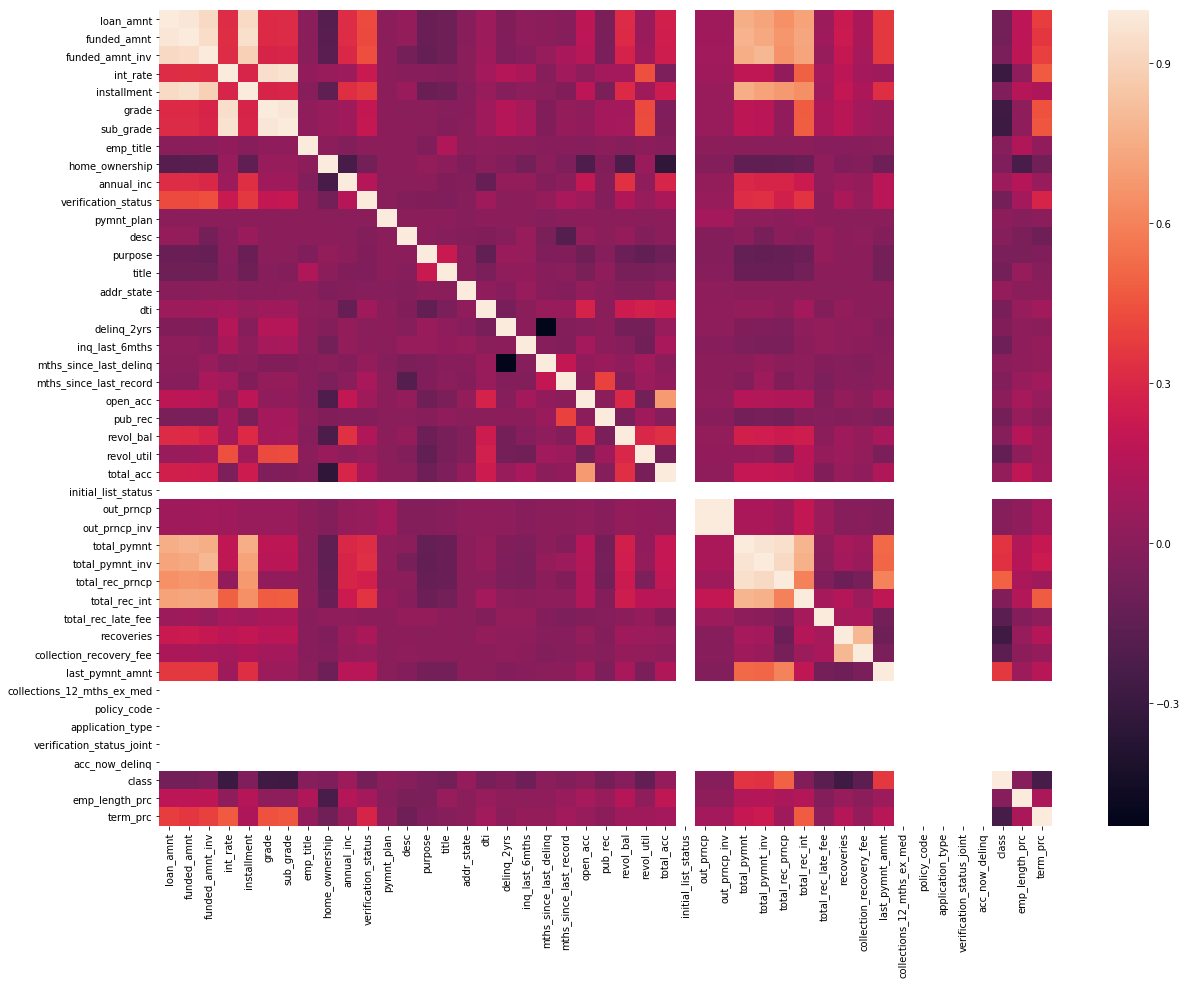

In [38]:
# Ayuda de: https://stackoverflow.com/questions/29432629/correlation-matrix-using-pandas
# https://datascience.stackexchange.com/questions/17540/make-seaborn-heatmap-bigger
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.subplots(figsize=(20,15))
corr = data_clear_f2.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)